In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import glob, pathlib
import numpy as np
import pandas as pd
import math

In [16]:
drop = [ "Unnamed: 0", "SimillarHTTP", "Bwd Avg Bulk Rate",
        "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd PSH Flags",
        "Bwd URG Flags", "ECE Flag Count", "FIN Flag Count",
        "Fwd Avg Bulk Rate", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk",
        "Fwd URG Flags", "PSH Flag Count"]

variables = [
    "Average Packet Size",
    "Avg Fwd Segment Size",
    "Destination Port",
    "Flow Bytes/s",
    "Fwd Packet Length Min",
    "Inbound",
    "Source Port",
    "URG Flag Count",
]

sample_percentage = {
    "LDAP": 0.1,
    "MSSQL": 0.28,
    "NetBIOS": 0.17,
    "Portmap": 0.009,
    "Syn": 0.2,
    "UDP": 0.18,
    "UDPLag": 0.03,
}


In [ ]:
for file_name in glob.glob("dataset/*.csv"):
    name = pathlib.Path(file_name).name.split(".")[0]
    out = "clean" + name + ".csv"
    df = pd.read_csv(file_name, usecols=lambda c: c.strip() not in drop)
    cols_map = {col: col.strip() for col in df.columns}
    df.rename(columns=cols_map, inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.to_csv(out,index=False)

In [3]:
file_names = glob.glob("dataset/clean/*.csv")
for file_name in file_names:
    name = pathlib.Path(file_name).name.split(".")[0]
    df = pd.read_csv(file_name)
    df[df["Label"] == "BENIGN"].to_csv("Benign " + name + ".csv", index=False)
    df[df["Label"] != "BENIGN"].to_csv("Attack " + name + ".csv", index=False)

In [13]:
benigns = []
for file in sample_percentage.keys():
    name = "Benign clean" + file + ".csv"
    df = pd.read_csv(name)
    benigns.append(df)

benigns = pd.concat(benigns)
benigns.to_csv("Benign.csv", index=False)
benign_size = len(benigns)

attacks = []
for file, p in sample_percentage.items():
    name = "Attack clean" + file + ".csv"
    sample_size = math.floor(p * benign_size)
    df = pd.read_csv(name).sample(sample_size)
    attacks.append(df)

attacks = pd.concat(attacks)
benigns.to_csv("Attack.csv", index=False)

In [ ]:
df1 = pd.read_csv("dataset/Attack.csv")
df2 = pd.read_csv("dataset/Benign.csv")
df = pd.concat([df1, df2])
df.to_csv("final.csv", index=False)

<AxesSubplot:ylabel='Destination Port'>

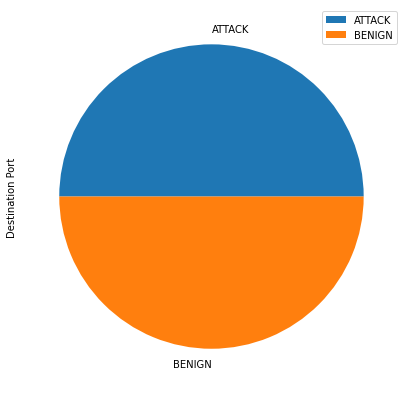

In [6]:
dataset = pd.read_csv("final.csv")
dataset.groupby("Label").count().plot(figsize=(7,7),kind="pie", y="Destination Port")

In [7]:
dataset = pd.read_csv("final.csv")

le = LabelEncoder()
le.fit(dataset["Label"])

dataset["Label"] = le.transform(dataset["Label"])
dataset = dataset.select_dtypes(exclude="object")
xs_df = dataset.drop("Label", axis=1)
ys_df = dataset["Label"]

### Correlation

<BarContainer object of 69 artists>

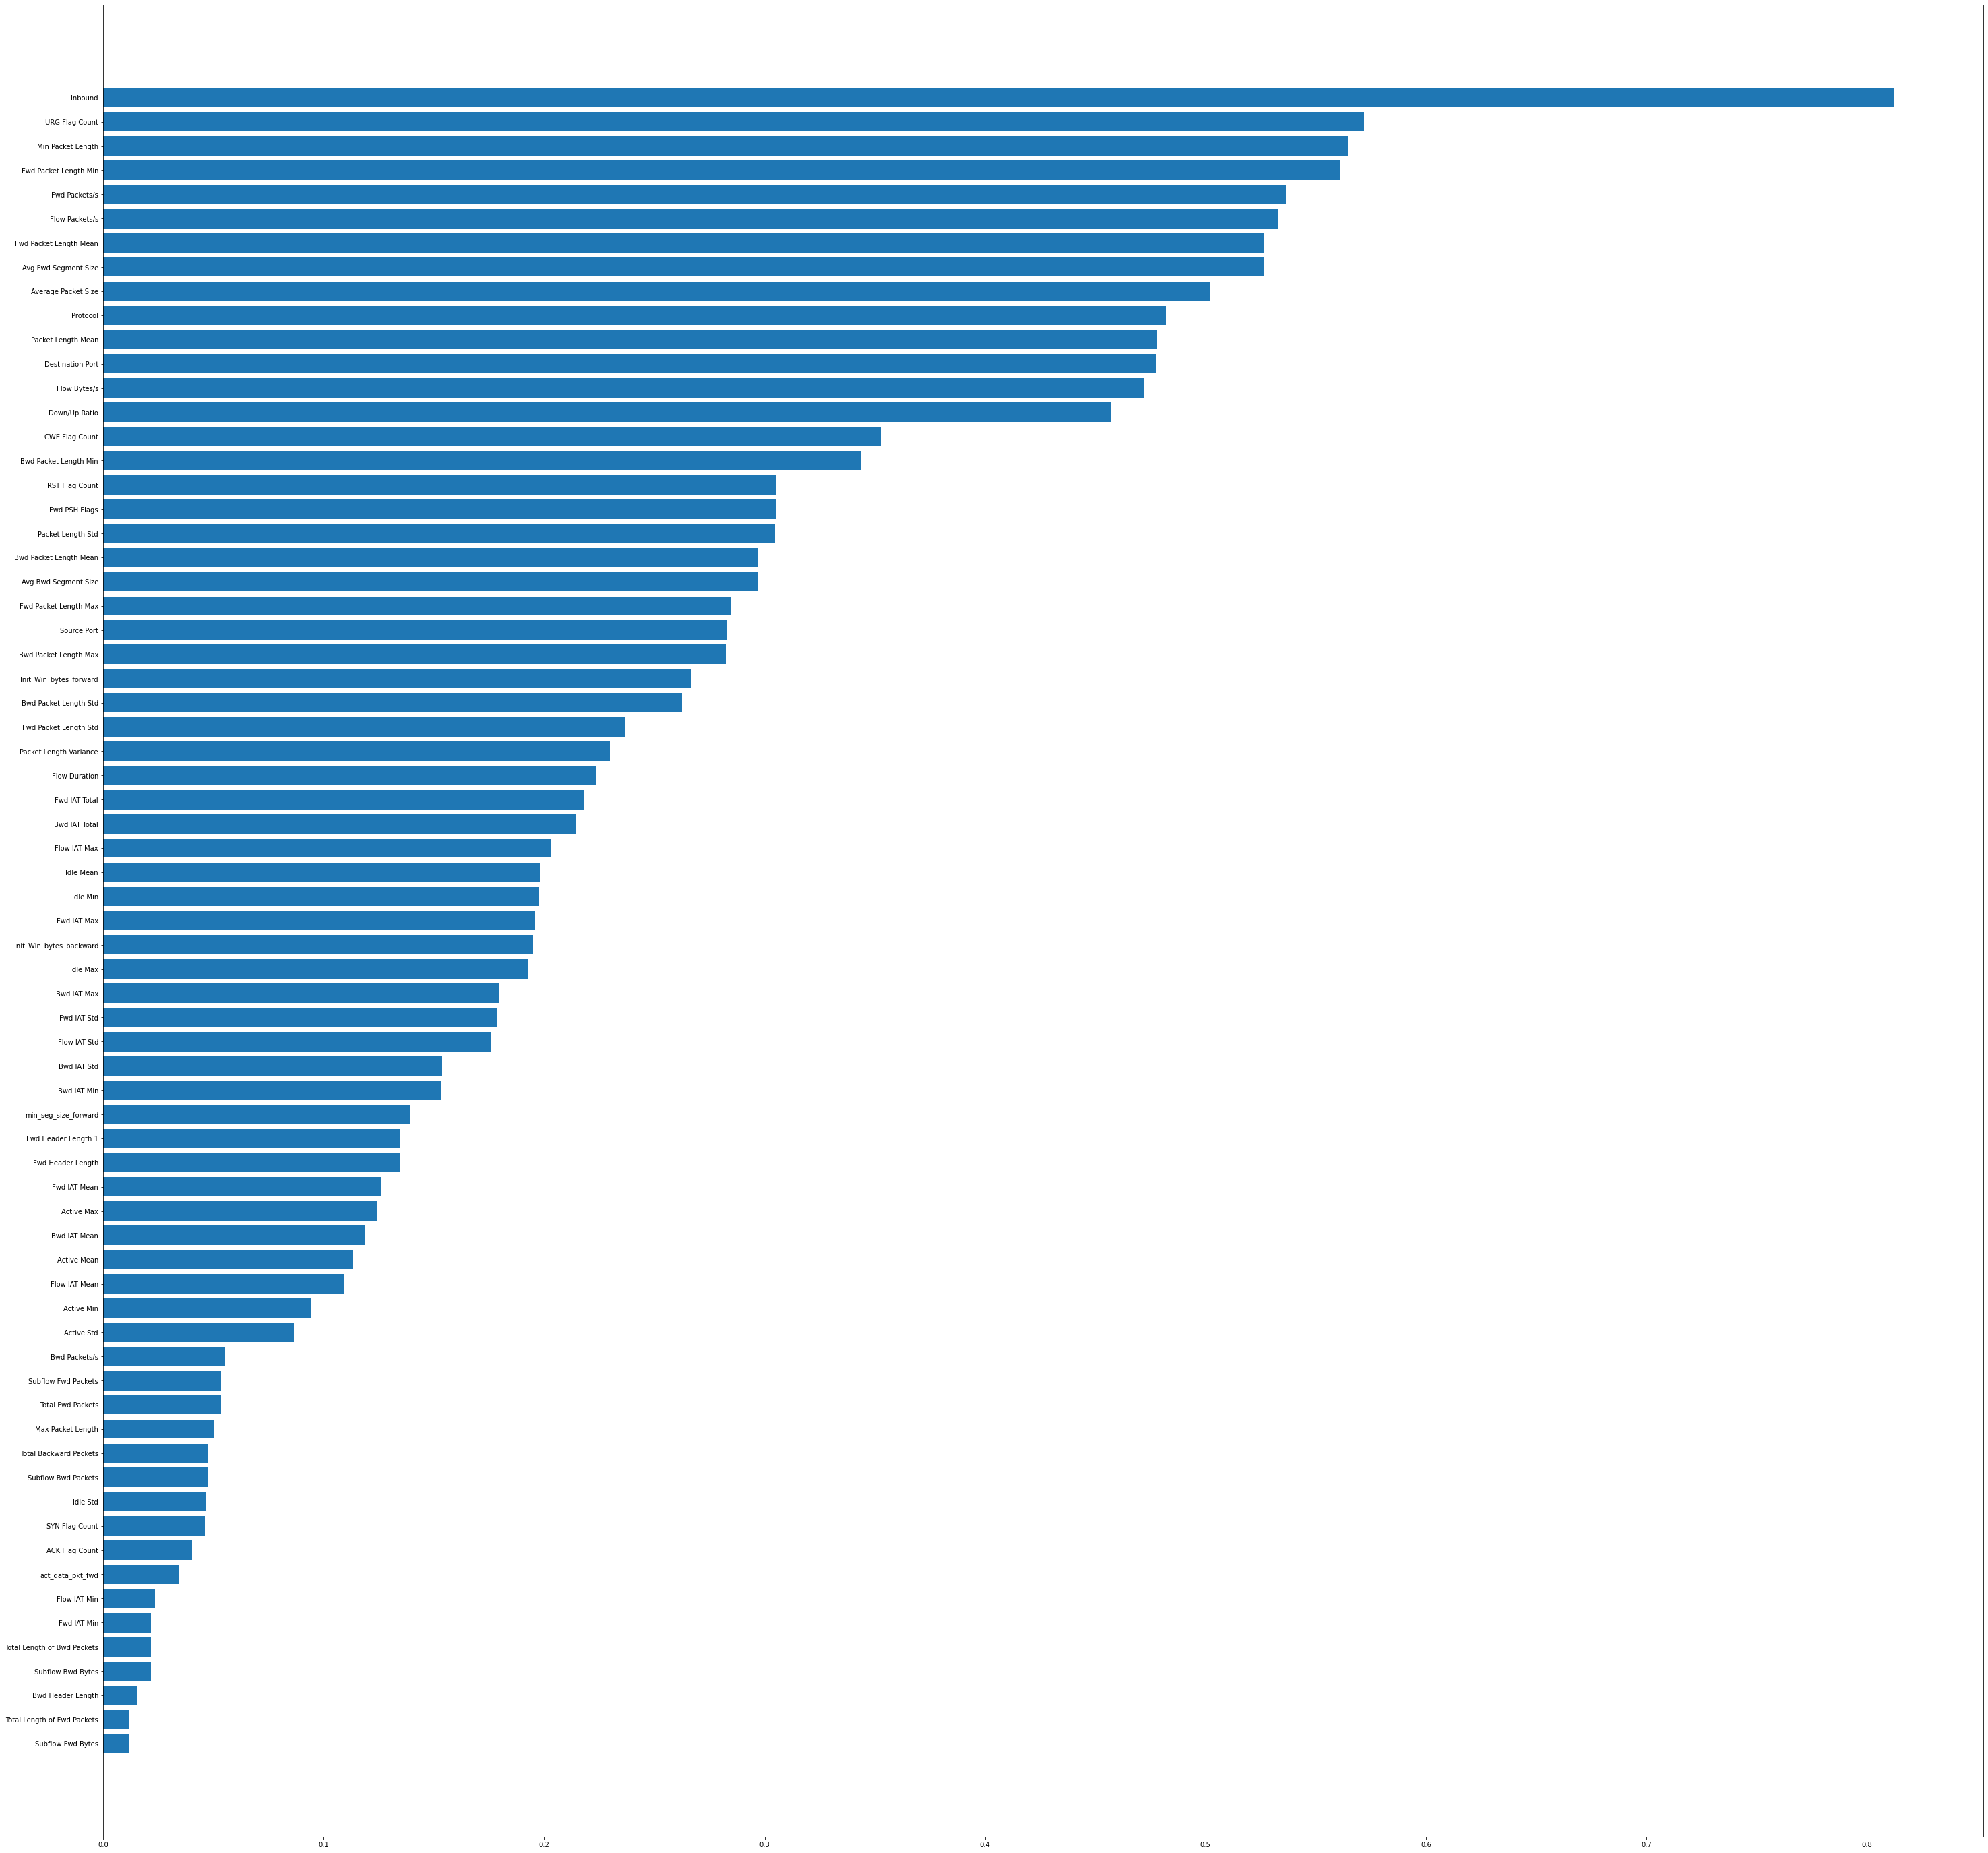

In [13]:
correlations = dataset.corr(method ='pearson')["Label"].map(abs)
correlations = correlations.drop("Label").values
index = correlations.argsort()
df = dataset.drop("Label", axis=1)
plt.figure(figsize=(50, 50))
plt.barh(df.columns[index], correlations[index])

### Decision Tree

<BarContainer object of 69 artists>

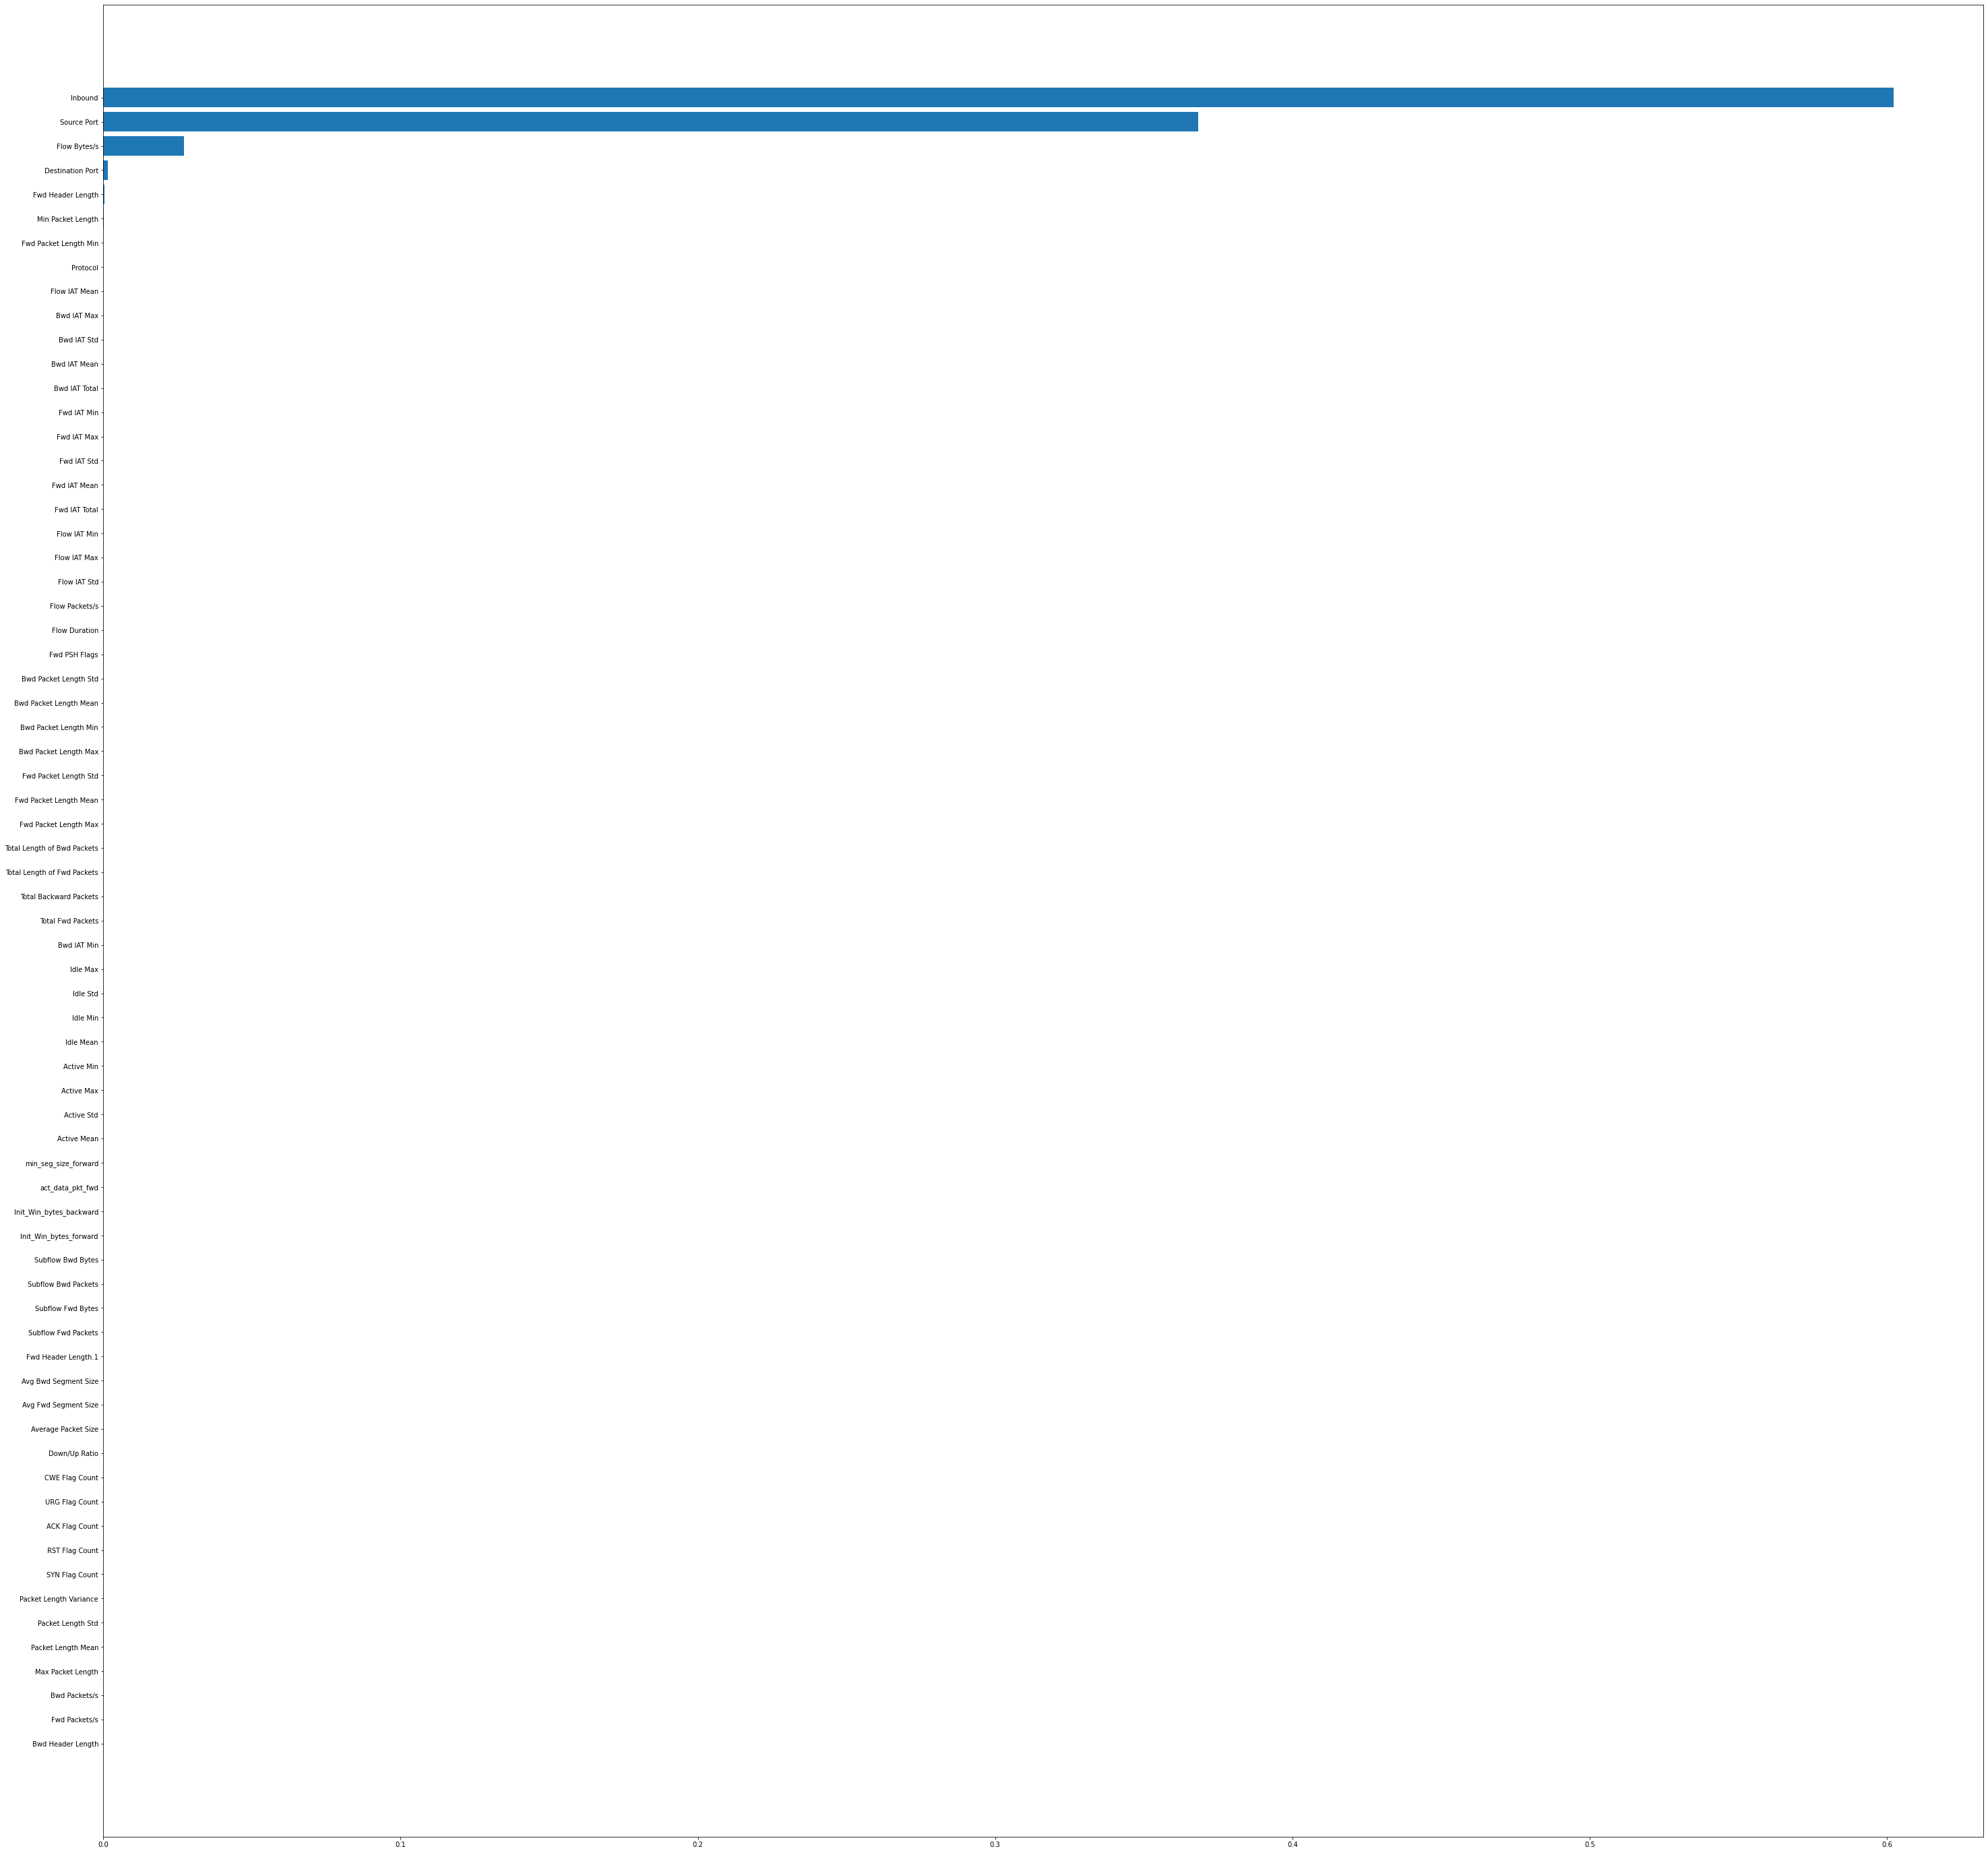

In [14]:
dt = DecisionTreeClassifier(criterion="entropy")
dt.fit(xs_df, ys_df)

fi = dt.feature_importances_
index = fi.argsort()
df = dataset.drop("Label", axis=1)
plt.figure(figsize=(50, 50))
plt.barh(xs_df.columns[index], fi[index])

### Random Forest

<BarContainer object of 69 artists>

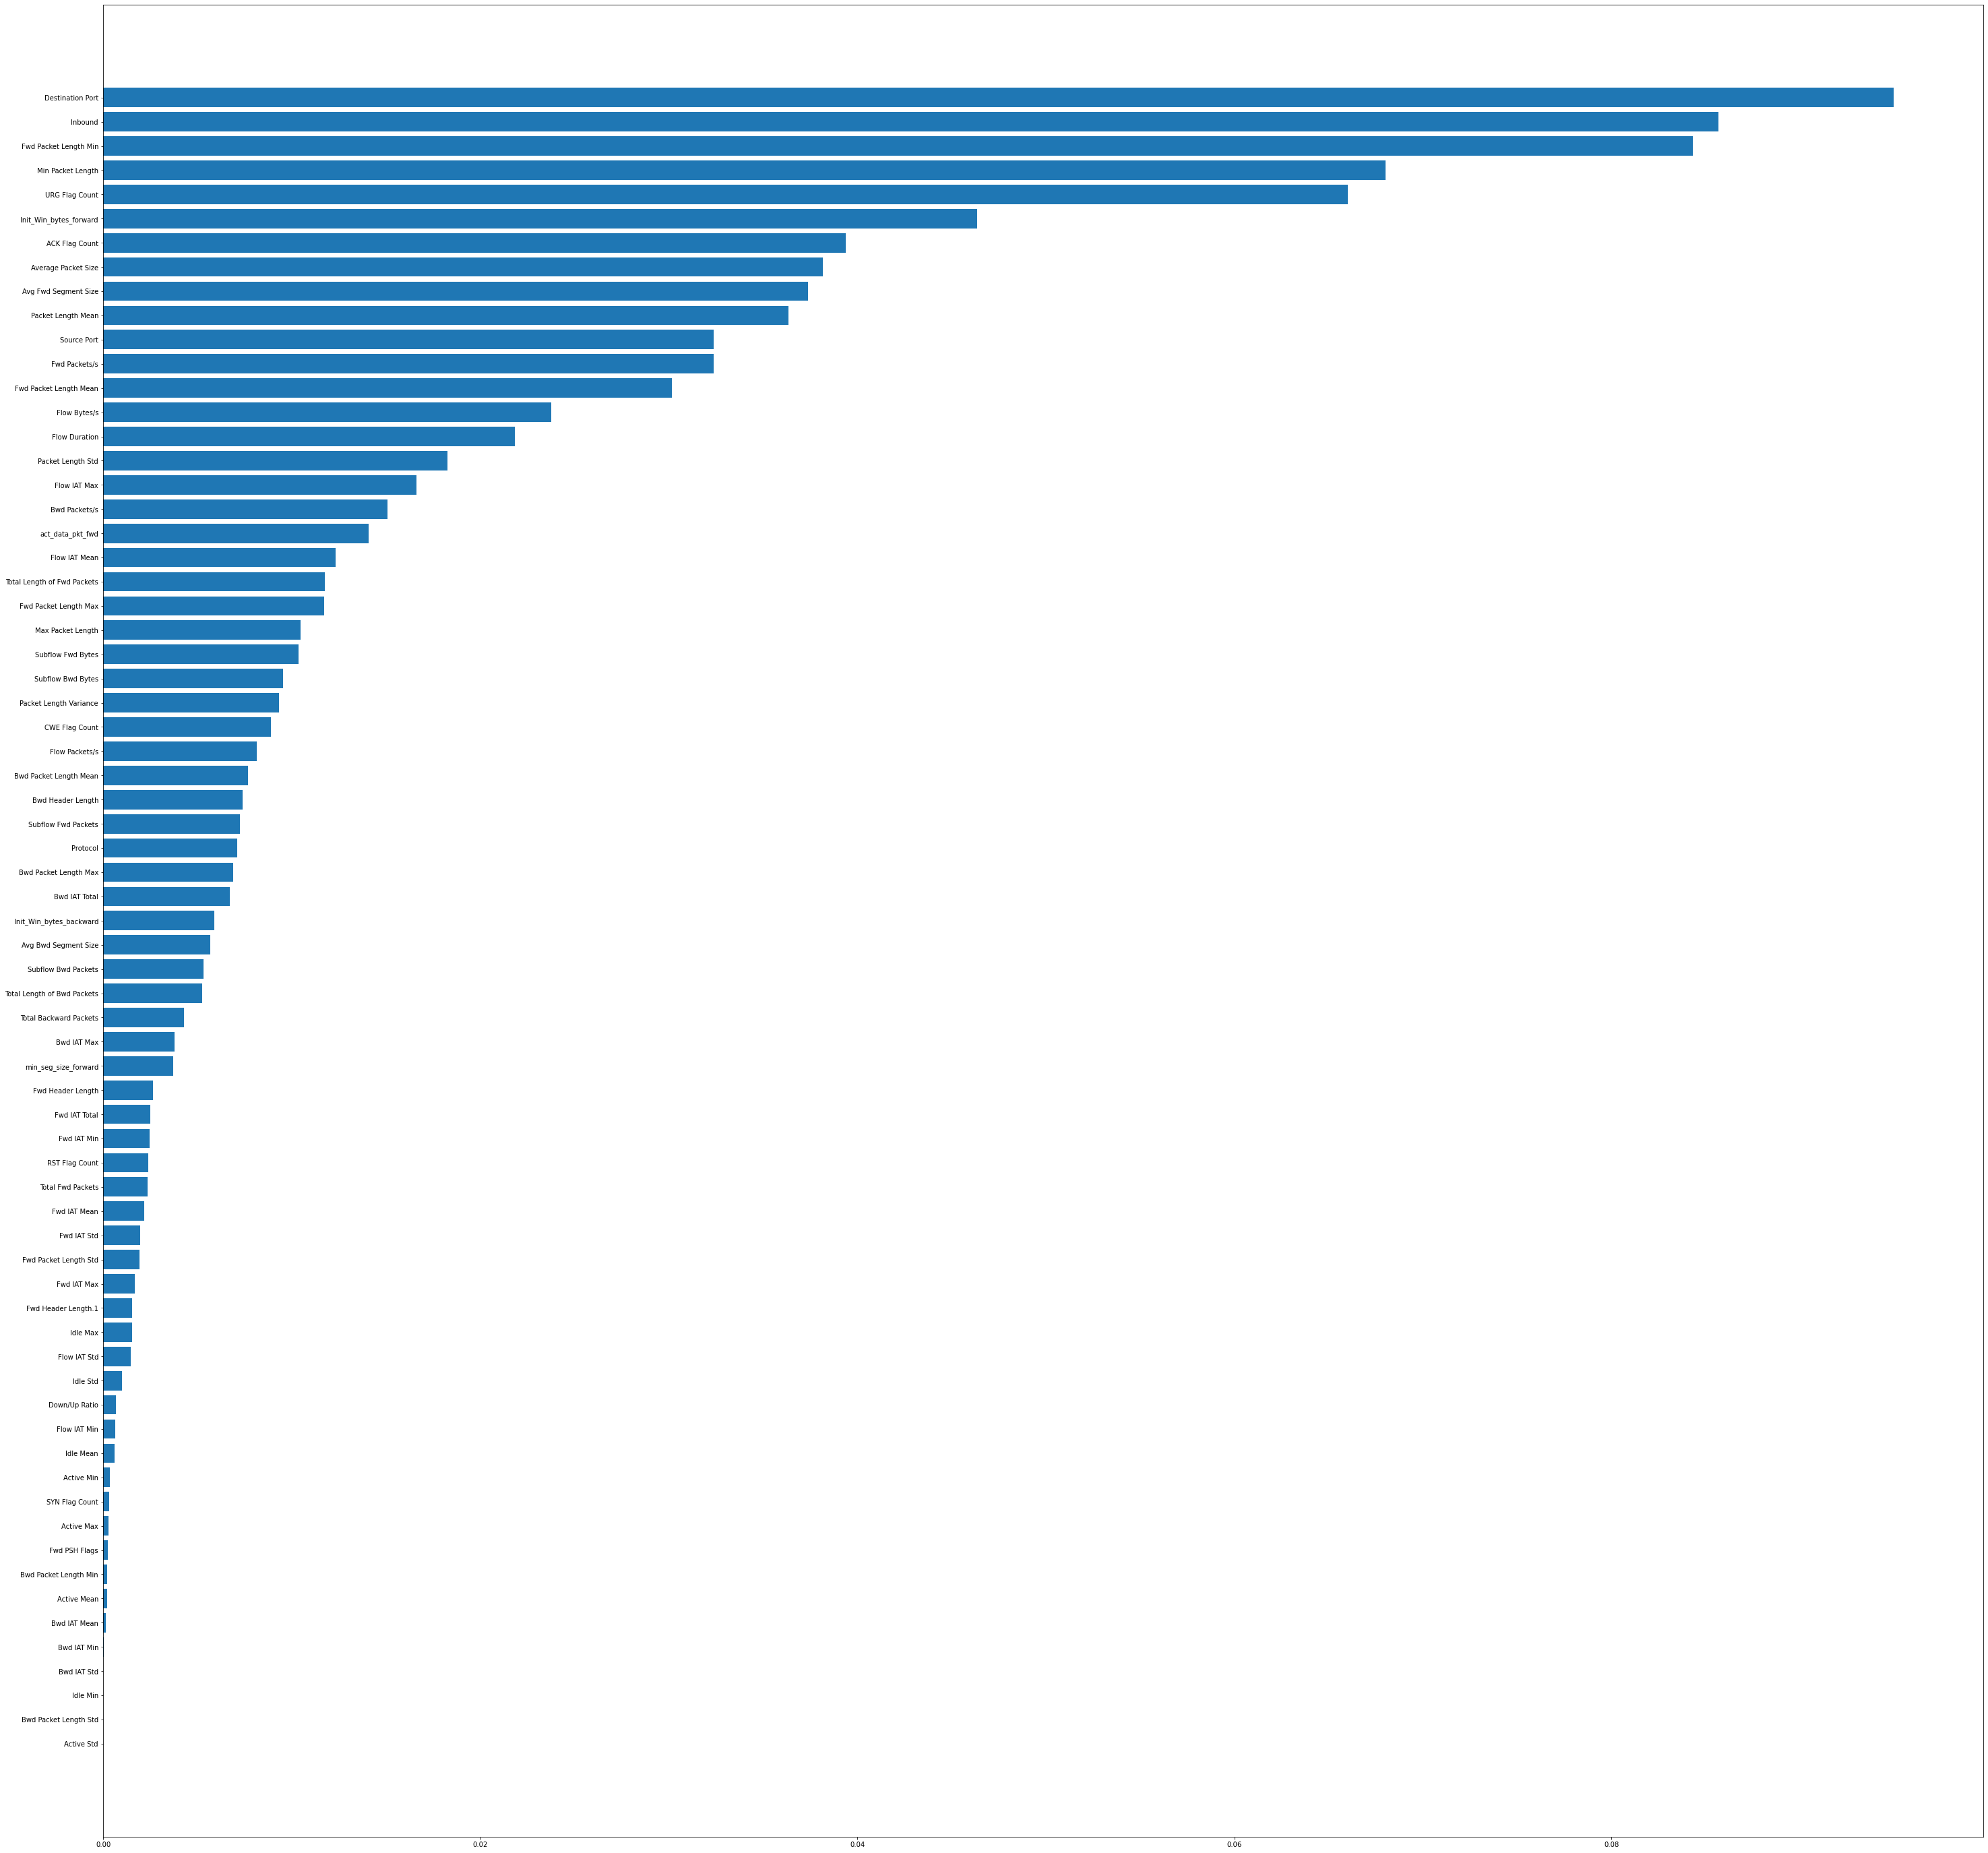

In [67]:
rf = RandomForestClassifier(criterion="entropy")
rf.fit(xs_df, ys_df)

fi = rf.feature_importances_
index = fi.argsort()
df = dataset.drop("Label", axis=1)
plt.figure(figsize=(50, 50))
plt.barh(xs_df.columns[index], fi[index])

In [19]:
xs = normalize(xs_df[variables])
ys = ys_df.values
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3)
kf = KFold(n_splits=10)

### Logistic Regression

accuracy: 0.7837117848534821
precision: 0.8469065656565656
recall: 0.687419933384576
fscore: 0.7588742752085984
**********
accuracy: 0.7824432322719777
precision: 0.8514106583072101
recall: 0.6863785696234521
fscore: 0.7600391772771793
**********
accuracy: 0.7839654953697831
precision: 0.8440024860161591
recall: 0.6933877967832525
fscore: 0.7613174491941135
**********
accuracy: 0.7813015349486236
precision: 0.8499539736115372
recall: 0.6916354556803995
fscore: 0.7626651982378855
**********
accuracy: 0.7824432322719777
precision: 0.8541797611565053
recall: 0.6848072562358276
fscore: 0.7601734023213536
**********
accuracy: 0.7839380867800051
precision: 0.8622222222222222
recall: 0.681555834378921
fscore: 0.7613174491941136
**********
accuracy: 0.7786094899771632
precision: 0.8409163219853643
recall: 0.6797839506172839
fscore: 0.7518133978096999
**********
accuracy: 0.7869829992387719
precision: 0.85633626097867
recall: 0.6909643128321944
fscore: 0.7648129990194704
**********
accuracy: 0.

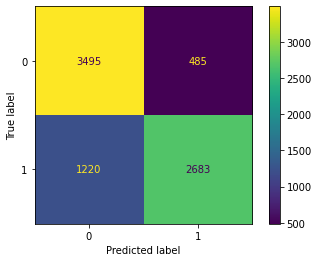

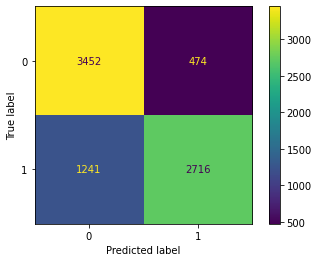

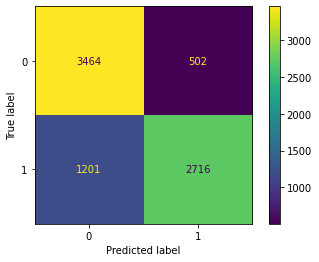

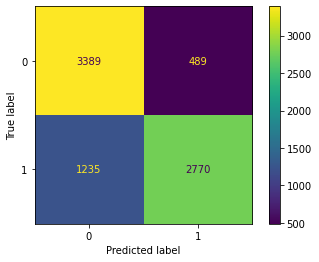

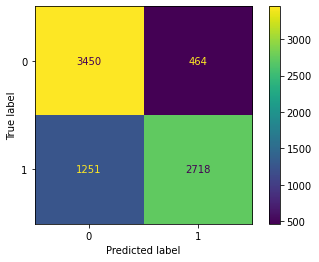

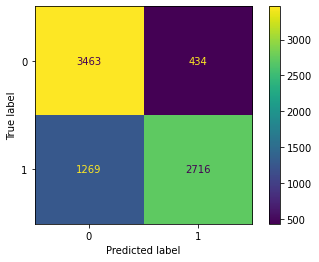

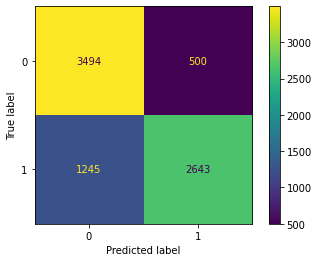

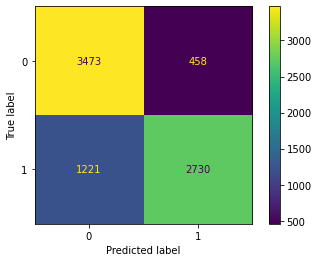

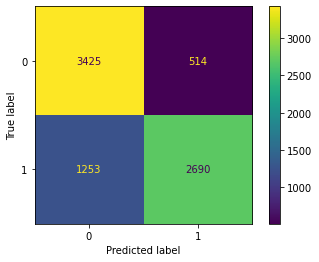

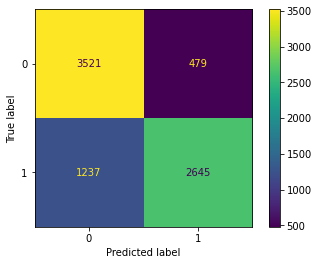

In [20]:
for i_train, i_val in kf.split(x_train):
    x_t = x_train[i_train]
    y_t = y_train[i_train]
    x_v = x_train[i_val]
    y_v = y_train[i_val]
    ps = LogisticRegression().fit(x_t, y_t).predict(x_v)

    print("accuracy:", accuracy_score(y_v, ps))
    print("precision:", precision_score(y_v, ps))
    print("recall:", recall_score(y_v, ps))
    print("fscore:", f1_score(y_v, ps))
    print("*"*10)
    ConfusionMatrixDisplay.from_predictions(y_v, ps)

### Support Vector Machine

accuracy: 0.8843080045667893
precision: 0.9828866645140458
recall: 0.7799128875224186
fscore: 0.8697142857142857
**********
accuracy: 0.8832931625015857
precision: 0.9840612049729041
recall: 0.78013646702047
fscore: 0.8703129405131096
**********
accuracy: 0.8822783204363821
precision: 0.9838135318873422
recall: 0.7758488639264743
fscore: 0.8675421067656296
**********
accuracy: 0.881136623113028
precision: 0.9839116719242902
recall: 0.7787765293383271
fscore: 0.8694076655052265
**********
accuracy: 0.8802486363059748
precision: 0.985553772070626
recall: 0.7734945830183926
fscore: 0.8667419536984754
**********
accuracy: 0.8828977416899264
precision: 0.9878903760356915
recall: 0.7779171894604768
fscore: 0.870419766952127
**********
accuracy: 0.8807409286982999
precision: 0.9845496383957922
recall: 0.7703189300411523
fscore: 0.8643578643578644
**********
accuracy: 0.884673940624207
precision: 0.9837786259541985
recall: 0.782839787395596
fscore: 0.8718816067653276
**********
accuracy: 0.881

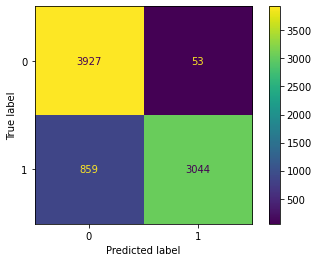

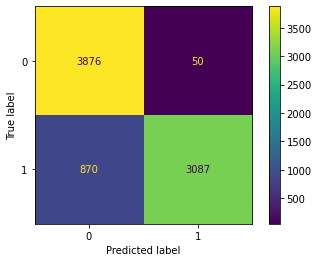

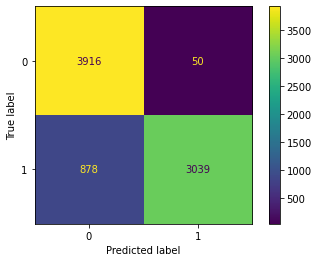

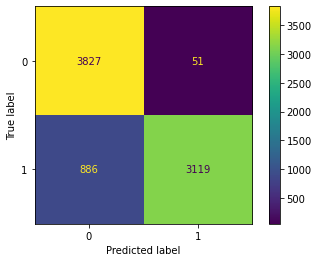

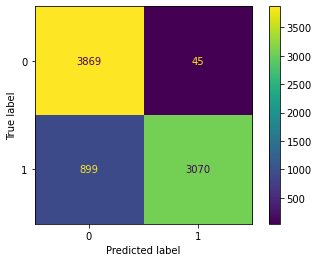

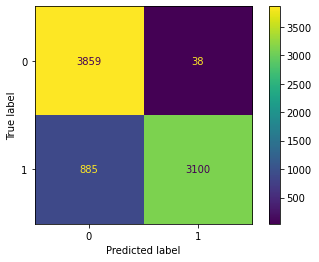

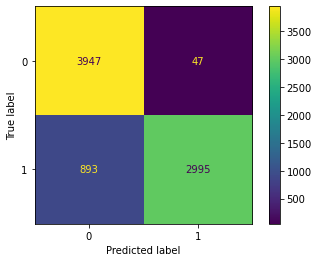

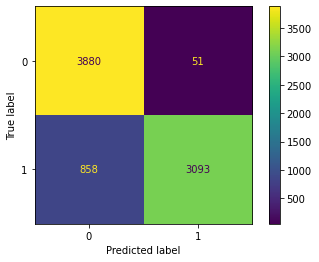

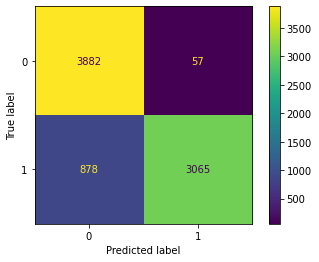

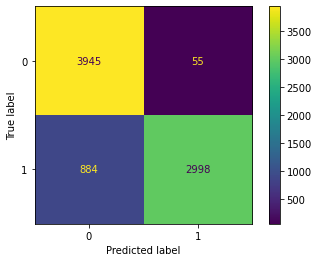

In [21]:

for i_train, i_val in kf.split(x_train):
    x_t = x_train[i_train]
    y_t = y_train[i_train]
    x_v = x_train[i_val]
    y_v = y_train[i_val]
    ps = SVC(gamma="auto").fit(x_t, y_t).predict(x_v)

    print("accuracy:", accuracy_score(y_v, ps))
    print("precision:", precision_score(y_v, ps))
    print("recall:", recall_score(y_v, ps))
    print("fscore:", f1_score(y_v, ps))
    print("*"*10)
    ConfusionMatrixDisplay.from_predictions(y_v, ps)

### Decision Tree

accuracy: 0.9994925789673982
precision: 0.9992376111817026
recall: 0.9997457411645054
fscore: 0.9994916115912555
**********
accuracy: 0.9998731447418495
precision: 0.9997457411645054
recall: 1.0
fscore: 0.999872854418309
**********
accuracy: 0.9996194342255487
precision: 0.9994895354772844
recall: 0.999744702578504
fscore: 0.9996171027440971
**********
accuracy: 0.9996194342255487
precision: 0.9994958406856567
recall: 0.9997478567826525
fscore: 0.9996218328501197
**********
accuracy: 0.9998731447418495
precision: 0.9997486173956762
recall: 1.0
fscore: 0.9998742928975487
**********
accuracy: 0.9998731286475514
precision: 0.9997483010319658
recall: 1.0
fscore: 0.9998741346758967
**********
accuracy: 0.9997462572951028
precision: 0.9997493106041614
recall: 0.9997493106041614
fscore: 0.9997493106041614
**********
accuracy: 0.9991119005328597
precision: 0.9994966020639315
recall: 0.9987424547283702
fscore: 0.9991193860863
**********
accuracy: 0.9994925145902055
precision: 0.9994921279837481

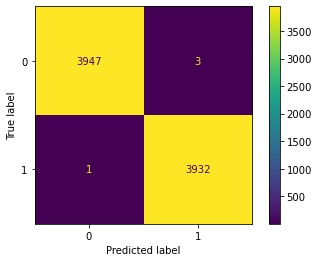

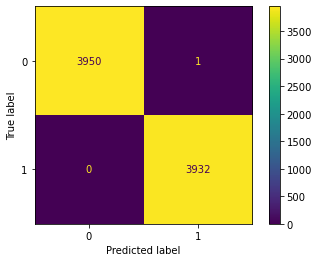

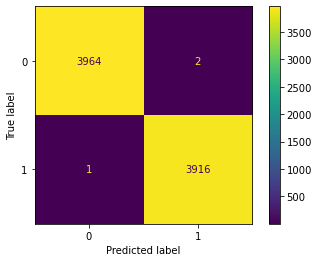

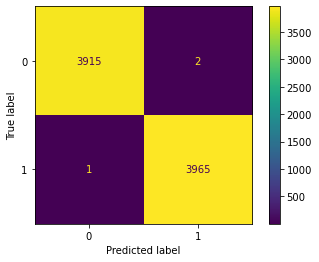

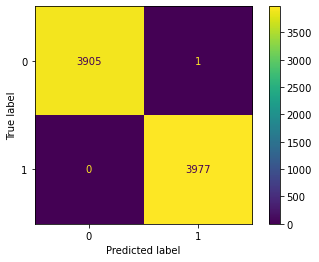

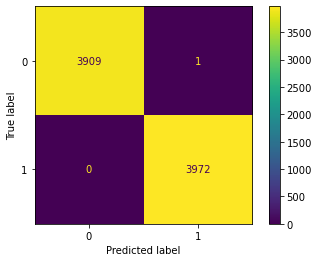

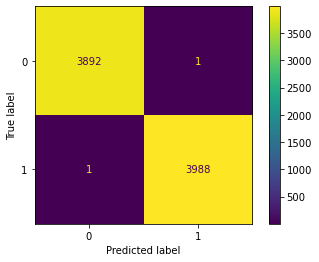

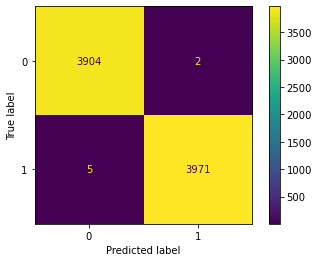

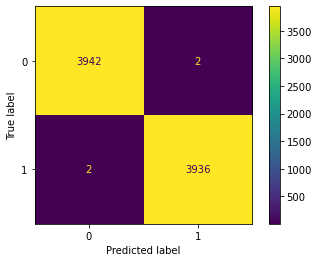

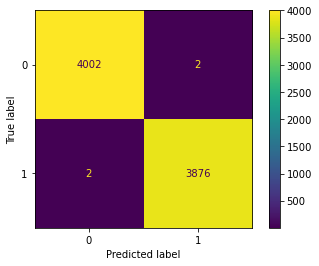

In [58]:
for i_train, i_val in kf.split(x_train):
    x_t = x_train[i_train]
    y_t = y_train[i_train]
    x_v = x_train[i_val]
    y_v = y_train[i_val]
    ps = DecisionTreeClassifier(criterion="gini").fit(x_t, y_t).predict(x_v)

    print("accuracy:", accuracy_score(y_v, ps))
    print("precision:", precision_score(y_v, ps))
    print("recall:", recall_score(y_v, ps))
    print("fscore:", f1_score(y_v, ps))
    print("*"*10)
    ConfusionMatrixDisplay.from_predictions(y_v, ps)


### Random Forest

accuracy: 0.9998731447418495
precision: 0.9997458057956279
recall: 1.0
fscore: 0.9998728867420872
**********
accuracy: 0.9996194342255487
precision: 0.999491482329011
recall: 0.9997456765005086
fscore: 0.9996185632549268
**********
accuracy: 0.9994925789673982
precision: 0.9994894051570079
recall: 0.9994894051570079
fscore: 0.9994894051570079
**********
accuracy: 0.9996194342255487
precision: 0.9994958406856567
recall: 0.9997478567826525
fscore: 0.9996218328501197
**********
accuracy: 0.9997462894836991
precision: 0.9997485541865728
recall: 0.9997485541865728
fscore: 0.9997485541865728
**********
accuracy: 0.9997462572951028
precision: 0.9997482376636455
recall: 0.9997482376636455
fscore: 0.9997482376636455
**********
accuracy: 0.9996193859426542
precision: 0.9994987468671679
recall: 0.9997493106041614
fscore: 0.9996240130342148
**********
accuracy: 0.9996193859426542
precision: 0.9994971083731455
recall: 0.9997484909456741
fscore: 0.999622783855149
**********
accuracy: 0.9998731286475

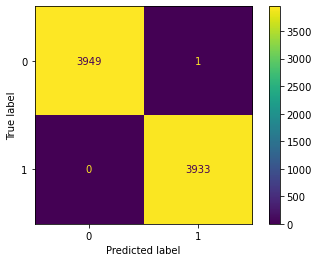

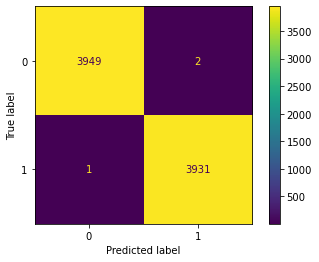

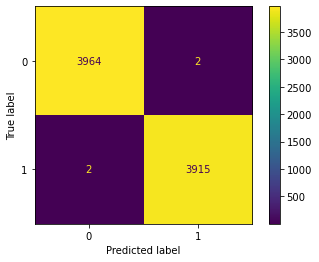

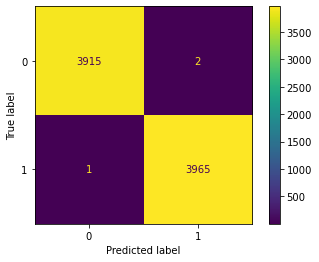

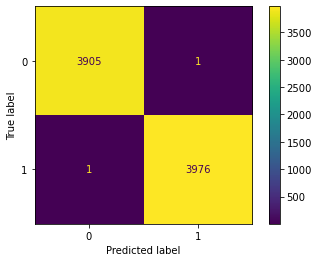

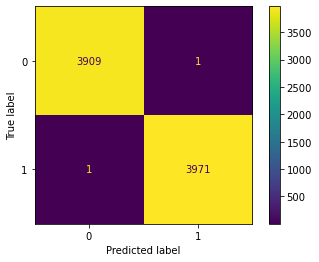

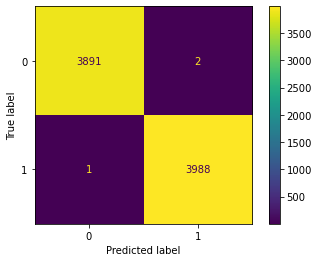

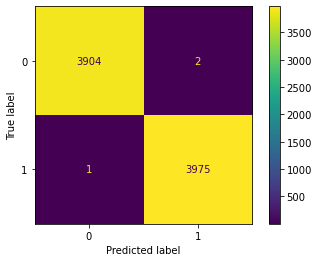

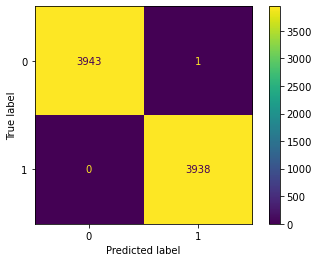

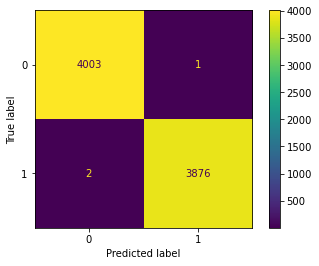

In [59]:
for i_train, i_val in kf.split(x_train):
    x_t = x_train[i_train]
    y_t = y_train[i_train]
    x_v = x_train[i_val]
    y_v = y_train[i_val]
    ps = RandomForestClassifier().fit(x_t, y_t).predict(x_v)

    print("accuracy:", accuracy_score(y_v, ps))
    print("precision:", precision_score(y_v, ps))
    print("recall:", recall_score(y_v, ps))
    print("fscore:", f1_score(y_v, ps))
    print("*"*10)
    ConfusionMatrixDisplay.from_predictions(y_v, ps)